##Getting Started:

This is an IPython notebook.  IPython notebooks are open-source programming tools that run in a web browser, and offer a lot of flexibility and power for scientific computing tasks.  Because they are portable and self-contained, they are ideal for education and [reproducable research](http://reproducibleresearch.net/). Notebooks are made of a single column of 'cells' that usually consist of markdown or code.  Markdown cells like this one and the one above support basic [markdown formatting](https://en.wikipedia.org/wiki/Markdown), as well as $\LaTeX$ statements.  The cell below is a code cell, which runs Python code any time the 'play button' or Shift-Enter is pressed.  The Python commands can be run over and over, or the background processes can be stopped or restarted without affecting this notebook.  Did I mention flexibility? Cells can be reordered, and the whole notebook can be saved as a PDF document.

Scientific applications of the Python progamming language have increased dramatically over the past few years.  Its simplicity, versatility, and power has made it a first-choice language for many scientists and engineers.  Just enter "`import antigravity`" in a code cell or at a Python prompt to see the zeal Python inspires.

To get started, the main function libraries in Python for working with numbers are `numpy` and `pandas`. Standard numerical methods are often in the `scipy` library.  The `sklearn` library has fitting and regression, and `matplotlib` is used for matlab-style plots.  To begin our Python session, these libraries and some specific functions are imported in the cell below:

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
from scipy.integrate import odeint

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
# turn on inline plotting for this notebook:
%matplotlib inline

# Reference

This hastily written notebook attempts to replicate the workflow and results of M. Shacham's "Using Templates for Demonstrating Good Programming Practices" submitted to the 2015 Annual AIChE meeting: [ftp site](ftp://ftp.bgu.ac.il/shacham/templates/)



#Basic Numerical Problem Solving with Python

##One Nonlinear (Implicit) Algebraic Equation

Solve the followng system of equations:

$$P=\frac{RT}{\left(V-b\right)}-\frac{\alpha a}{V\left(V+b\right)}$$

where:

$$a=0.42747\left(\frac{R^2T_c^2}{P_c}\right)$$

$$b=0.08664\left(\frac{RT_c}{P_c}\right)$$

$$m=0.48508+1.55171\bar{\omega}-0.1561\bar{\omega}^2$$

$$\alpha=\left[1+m\left(1-\sqrt{T/T_c}\right)\right]$$

Create a Python function for the first equation, set equal to zero:

In [2]:
def f(V):
    return R*T/(V-b)-alph*a/(V*(V+b))-P

Enter some constants

In [3]:
R=0.08206 #Gas constant (L-atm/gmol-K)
P_c=72.9
T_c=304.2
w_bar=0.225
T=300.
P=100.
a=0.42747*(R**2.0*T_c**2.0/P_c)
b=0.08664*(R*T_c/P_c)
m=0.48508+1.55171*w_bar-0.1561*w_bar**2
alph=(1+m*(1-np.sqrt(T/T_c)))**2

Print out values, and solve equation with initial guess

In [4]:
print('initial f(V0)= %f' %f(0.07))
print('a = %f' %a)
print('b = %f' %b)
print('m = %f' %m)
print('alpha = %f' %(alph))
print('V= %f' %(fsolve(f,0.07))) # Print out solution result

initial f(V0)= -19.366385
a = 3.653924
b = 0.029668
m = 0.826312
alpha = 1.011481
V= 0.064113


The final result of the optimization is $V = 0.0641$

## A System of Nonlinear Algebraic Equations (NLE)

The following is a system of ultrafiltration equations from Cutlip and Shackam, 2013

$$Q_1c_1=Q_0c_0$$

$$Q_1=Q_0-j_1A$$

$$j_1=k\ln\left(c_g/c_1\right)$$

$$Q_2c_2=Q_1c_1$$

$$j_2=k\ln\left(c_g/c_2\right)$$

$$Q_3c_3=Q_2c_2$$

$$Q_3=Q_2-j_3A$$

$$j_3=k\ln\left(c_g/c_3\right)$$

$$Q_0=1/(60\times1000)$$

$$k=3.5e-6$$

In [5]:
cg=300
c0=10
A=0.9
k=3.5e-6
Q0=1/(60.0*1000.0)
Const=[cg,c0,A,k,Q0]
xguess=[40.0,70.0,150.0]

def Evarfun(x,Const):
    c1,c2,c3 = x # unpack concentrations
    cg,c0,A,k,Q0 = Const # unpack constants
    j1=k*np.log(cg/c1)
    Q1=c0*Q0/c1
    j2=k*np.log(cg/c2)
    Q2=c1*Q1/c2
    j3=k*np.log(cg/c3)
    Q3=c2*Q2/c3
    Evar=[j1,j2,j3,Q1,Q2,Q3]
    return Evar

def MNLEfun(x,Const):
    c1,c2,c3=x# unpack concentrations
    cg,c0,A,k,Q0 = Const # unpack constants
    j1=k*np.log(cg/c1)
    Q1=c0*Q0/c1
    j2=k*np.log(cg/c2)
    Q2=c1*Q1/c2
    j3=k*np.log(cg/c3)
    Q3=c2*Q2/c3
    fx=[Q0-Q1-(j1*A),Q1-Q2-(j2*A),Q2-Q3-(j3*A)]
    return fx


Check function values at initial guesses:

In [6]:
evars_initial=Evarfun(xguess,Const)
var_names=['j1: ','j2: ','j3: ','Q1: ','Q2: ','Q3: ']
for var in zip(var_names,evars_initial):
    print(var[0]+'{:.2e}'.format(var[1]))

j1: 7.05e-06
j2: 5.09e-06
j3: 2.43e-06
Q1: 4.17e-06
Q2: 2.38e-06
Q3: 1.11e-06


OK, it is time to solve, note that the solver tolerance `xtol` must be reduced due to the very small function values:

In [7]:
c=fsolve(MNLEfun,xguess,args=Const,xtol=1e-13)
print('c1 = %.2f \nc2 = %.2f \nc3 = %.2f' %(c[0],c[1],c[2]))
print('function values = ' + str(MNLEfun(c,Const)))
evars_final=Evarfun(c,Const)
for var in zip(var_names,evars_final):
    print(var[0]+'{:.2e}'.format(var[1]))

c1 = 20.35 
c2 = 56.67 
c3 = 163.12
function values = [0.0, 0.0, -4.2351647362715017e-22]
j1: 9.42e-06
j2: 5.83e-06
j3: 2.13e-06
Q1: 8.19e-06
Q2: 2.94e-06
Q3: 1.02e-06


We are able to solve the equations for the values of $c_1,c_2$ and $c_3$ , note that the objective function values are all *very* nearly zero, indicating that we have accurately fit our model. The $c$ values as well as the $Q$ and $j$ values now fully describe the unit operation.

## Systems of First-Order Ordinary Differential Equations (ODEs) - Initial Value Problems (IVPs)

Multicomponent gas diffusion is described by the following system of equations:

$$ \frac{dC_A}{dz}=\frac{x_AN_B-x_BN_A}{D_{AB}}+\frac{x_AN_C-x_CN_A}{D_{AC}}$$

$$ \frac{dC_B}{dz}=\frac{x_BN_A-x_AN_B}{D_{AB}}+\frac{x_BN_C-x_CN_B}{D_{BC}}$$

$$ \frac{dC_C}{dz}=\frac{x_CN_A-x_AN_C}{D_{AC}}+\frac{x_CN_B-x_BN_C}{D_{BC}}$$

$$x_A=C_A/C_T$$

$$x_B=C_B/C_T$$

$$x_C=C_C/C_T$$

$$N_A=2.115\times10^{-4}$$

$$N_B=-4.143\times10^{-4}$$

$$N_C=0$$

$$D_{AB}=1.47\times10^{-4}$$

$$D_{AC}=1.075\times10^{-4}$$

$$D_{BC}=1.245\times10^{-4}$$

$$C_T=0.2/(0.082057\times328)$$


Define the function that calculates the derivatives at any point in time

In [8]:
def ODEfun(Yfunvec,z,NA,NB,NC,DAB,DBC,DAC,CT):
    CA,CB,CC=Yfunvec
    xA=CA/CT
    xB=CB/CT
    xC=CC/CT
    dCAdz=(xA*NB-(xB*NA))/DAB+(xA*NC-(xC*NA))/DAC
    dCBdz=(xB*NA-(xA*NB))/DAB+(xB*NC-(xC*NB))/DBC
    dCCdz=(xC*NA-(xA*NC))/DAC+(xC*NB-(xB*NC))/DBC
    return np.array([dCAdz,dCBdz,dCCdz])
    

Now, define the constants and run the integration

In [9]:
NA=0.00002115
NB=-0.0004143
NC=0
DAB=0.000147
DBC=0.0001245
DAC=0.0001075
CT=0.2/(0.082057*328)
Const=NA,NB,NC,DAB,DBC,DAC,CT

y0=[0.00022290,0,0.007208]
tspan=np.linspace(0,0.001,40)
ty=odeint(ODEfun,y0,tspan,args=Const)

Plot the results:

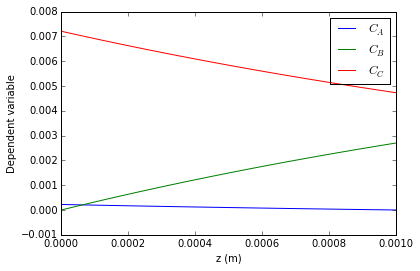

In [10]:
plt.plot(tspan,ty)
plt.legend(['$C_A$','$C_B$','$C_C$'])
plt.xlabel('z (m)')
plt.ylabel('Dependent variable')

Using our ODEs, we have described the gas concentrations over distance for the diffusion problem.  

## Linear and Polynomial Regression

Regressing model parameters for a linear or polynomial equation is very common and straightforward.  The goal in each case is determining the parameter values $b_0, b_1...b_n$ given a set of observations $y_i$ at different inputs $x_i$. 

The form of a linear equation is:

$$\hat{y_i}=b_0+b_1x_i$$

For a polynomial:

$$\hat{y_i}=b_0+b_1x_i+b_2x_i^2+...+b_nx_i^n$$

Where $\hat{y_i}$ is the calculated observation.  The goal of the regression is to find values of $b$ so that $\hat{y_i}$ matches $y_i$ for each of the values of $x_i$.  To do regression, we need data, which is typically a table.  For working with tables of data, the python `pandas` library is indespensible

In [11]:
# input data points
T=[290.08, 302.39, 311.19, 318.69, 325.1, 330.54, 334.89, 338.94,
   342.95, 346.24, 349.91, 353.47, 356.19, 358.87, 362.29, 365.23,
   367.9, 370.53, 373.15, 375.84, 378.52, 381.32,]
P=[8634, 15388, 22484, 30464, 38953, 47571, 55511, 63815, 72985,
   81275, 91346.0, 102040, 110850, 120140, 132780, 144530, 155800,
   167600, 180060, 193530, 207940, 223440]

# convert to data table- first stick T to P, then transpose and add labels
data=pd.DataFrame(np.transpose(np.vstack((T,P))),columns=['Temperature','Pressure'])
data # print out data table

,Temperature,Pressure
0,290.08,8634
1,302.39,15388
2,311.19,22484
3,318.69,30464
4,325.10,38953
5,330.54,47571
6,334.89,55511
7,338.94,63815
8,342.95,72985
9,346.24,81275


In [12]:
# Temperature and pressure are changed to column vectors for sklearn
X=data['Temperature'].values[:,np.newaxis] 
y=data['Pressure'].values[:,np.newaxis]
model=make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
model.fit(X,y)
yhat=model.predict(X)

Make plot of predicted vs. measured pressures, get your magnifying glasses...

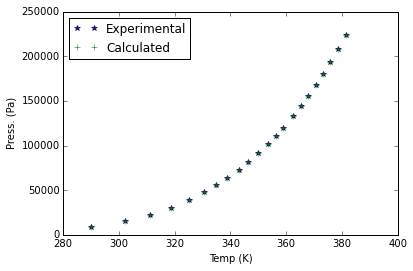

In [13]:
plt.plot(X,y,'b*',label='Experimental')
plt.plot(X,y,'g+',label='Calculated')
plt.legend(loc='best')
plt.xlabel('Temp (K)')
plt.ylabel('Press. (Pa)')
plt.show()

The experimental and calculated data points nearly overlap!

The plot of the residuals shows more diagnostics- the fact that these residual points are not randomly distributed indicates the equation we are fitting is not ideal:

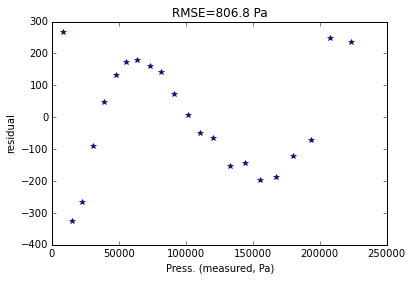

In [14]:
plt.plot(y,y-yhat,'b*')
plt.xlabel('Press. (measured, Pa)')
plt.ylabel('residual')
plt.title('RMSE=%.1f Pa' %(np.sqrt(sum((y-yhat)**2))))

To use the Riedel equation, which is a linear combination of some (nonlinear) treaments of the Temperature data:

$$ \log(P)=b_0+\frac{b_1}{T}+b_2\log(T)+b_3T^2$$

We calculate the $T$-containing terms, then stack them together and perform multiple linear regression:

In [15]:
T=data['Temperature'].values[:,np.newaxis] # Temperature and pressure are changed to column vectors
X=np.hstack((np.ones(T.shape),1/T,np.log10(T),T**2))
y=np.log10(data['Pressure'].values[:,np.newaxis])
model=LinearRegression(fit_intercept=False)
model.fit(X,y)
yhat=model.predict(X)

Spit out $b$ parameters:

In [16]:
for ix,b in enumerate(model.coef_.tolist()[0]):  # print out the coefficients
    print('b_%d = %.2e' %(ix,b))

b_0 = 4.04e+01
b_1 = -2.96e+03
b_2 = -1.08e+01
b_3 = 4.08e-06


Plot residuals:

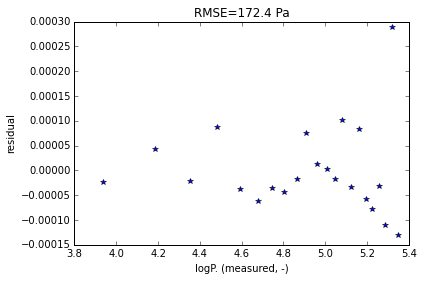

In [17]:
plt.plot(y,y-yhat,'b*')
plt.xlabel('logP. (measured, -)')
plt.ylabel('residual')
plt.title('RMSE=%.1f Pa' %(np.sqrt(sum((10**y-10**yhat)**2))))

These residuals look much better- no clear trends and much lower residual error.  The Riedel equation is better than the polynomial

## Nonlinear Regression

Regress P vs T data to the Antoine equation:
    
 $$ \log\left(P\right)=A+\frac{B}{T+C}$$
 
 We use `scipy`'s `curve_fit` with a custom function coding in the Antoine equation.  *Note: Doing curve fitting with log-transformed observations violates the assumtion of identically-distributed errors*

Define Antoine function, regress and print out best fit values of $A$, $B$, and $C$:

In [18]:
def NLRfun(X,A,B,C):
    T=X
    logP=A+B/(T+C)
    yhat=logP
    return yhat

X=data['Temperature'].values
y=np.log10(data['Pressure'].values)
Beta0=[10, -2000, 0]
Beta_names=['A: ','B: ','C: ']

beta,covar = curve_fit(NLRfun,X,y,p0=Beta0)
for b in zip(Beta_names, beta):
    print(b[0]+'{:.2f}'.format(b[1]))

A: 9.02
B: -1207.37
C: -52.77


Make plot of residuals, and also calculate the RMSE of the predicted pressures:

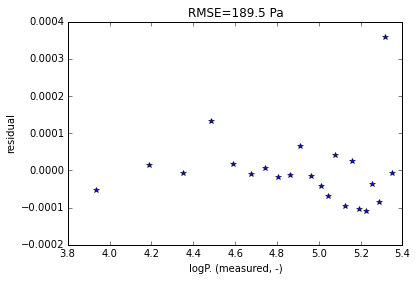

In [19]:
yhat=NLRfun(X,*beta)
plt.plot(y,y-yhat,'b*')
plt.xlabel('logP. (measured, -)')
plt.ylabel('residual')
plt.title('RMSE=%.1f Pa' %(np.sqrt(sum((10**y-10**yhat)**2))))

Try the regression again without the log-transformed pressure observations

In [20]:
def NLRfun(X,A,B,C):
    T=X
    P=np.exp(A+B/(T+C))
    yhat=P
    return yhat

X=data['Temperature'].values # Temperature and pressure are changed to column vectors
y=data['Pressure'].values
Beta0=[10, -2000, 0]
Beta_names=['A: ','B: ','C: ']

beta,covar = curve_fit(NLRfun,X,y,p0=Beta0)
for b in zip(Beta_names, beta):
    print(b[0]+'{:.2f}'.format(b[1]))

A: 20.81
B: -2797.54
C: -51.85


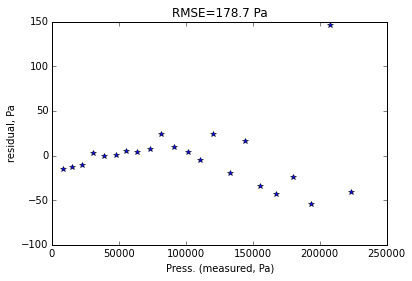

In [21]:
yhat=NLRfun(X,*beta)
plt.plot(y,y-yhat,'b*')
plt.xlabel('Press. (measured, Pa)')
plt.ylabel('residual, Pa')
plt.title('RMSE=%.1f Pa' %(np.sqrt(sum((y-yhat)**2))))

Here, the residuals look different, but in terms of obervation error, the RMSE is lower without fitting the log-transformed pressure observations.  The best fit values of $A$ and $B$ have also changed significantly.

#Conclusion

We have gone through many calculations common to chemical engineering (optimization, regression, integration) using Python.  Hopefully this has been an educational excersise in presenting Python as an accessable tool to quickly analyze data and models.  Feel free to download and edit this workbook as appropriate for your own needs!